In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

In [ ]:
from torchvision import datasets, transforms

# transform for normalizing the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


data_dir = './CIFAR10_data'

# CIFAR10 training and test datasets
trainset = datasets.CIFAR10(data_dir, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(data_dir, download=True, train=False, transform=transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

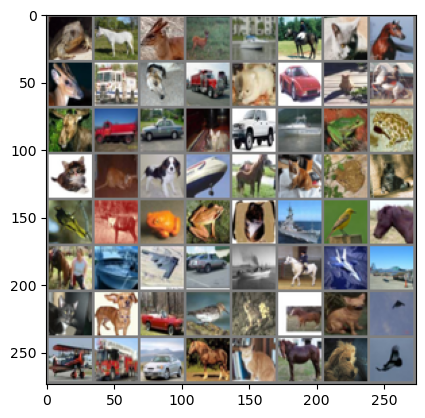

In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# example showcase
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor image
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [ ]:
class ConvBlock(nn.Module):
    """
    Block consisting of a convolutional layer, batch-norm, relu activation and max-pooling (if needed).
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, pool=False, pool_kernel_size=2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(pool_kernel_size) if pool else None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x, inplace=False)
        if self.pool is not None:
            x = self.pool(x)
        return x

class ResidualBlock(nn.Module):
    """
    Residual block consisting of 2 convolutional blocks.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv_block1 = ConvBlock(in_channels, out_channels, kernel_size, padding)
        self.conv_block2 = ConvBlock(out_channels, out_channels, kernel_size, padding)
        
    def forward(self, x):
        residual = x
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = torch.add(out, residual)  # Use torch.add instead of +=
        return out

class ResNet(nn.Module):
    """
    ResNet for CIFAR10: 8 convolutional layers, 1 fully-connected layer.
    """
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        self.conv_block1 = ConvBlock(in_channels, 64)
        self.conv_block2 = ConvBlock(64, 128, pool=True)
        self.res_block1 = ResidualBlock(128, 128)
        self.conv_block3 = ConvBlock(128, 256, pool=True)
        self.conv_block4 = ConvBlock(256, 512, pool=True)
        self.res_block2 = ResidualBlock(512, 512)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Adaptively pool to (1, 1) size
            nn.Flatten(),
            nn.Linear(512, num_classes)  # Ensure the in_features matches the flattened size
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.res_block1(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.res_block2(x)
        x = self.classifier(x)
        return x

In [ ]:
# simple network for testing
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) 
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(in_channels=3, num_classes=10)
model = model.to(device)

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, criterion, optimizer, trainloader, val_loader, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [ ]:
model = train_model(model, criterion, optimizer, trainloader, val_loader, num_epochs=20)